#Trabajo Final Grupo Nº 2

Rafael Perez	rafaelperezctes@gmail.com
Olinca Ayala	olincayalan88@gmail.com
###@Created on Dec Sat 2 16:57:20 2023
###@author: Grupo Nº 2


# Modulo guias

Este cuaderno realiza la descarga y análisis de secuencias nucleotídicas de integronas de Shewanella utilizando Biopython.


In [1]:
# @title Instalación de librerias
import subprocess
import ipywidgets as widgets
from IPython.display import display
import pkg_resources

def instalar_librerias():
    librerias = [
        "import_ipynb",
        "nbconvert",
        "ipywidgets",
        "biopython",
        "pandas",
        "numpy",
        "matplotlib",
        "tqdm",
        "odfpy",
        "requests",
        "gdown",
        "mafft",
        "clustalo",
        "muscle",
        "fasttree",
        "weblogo",
        "logomaker",

    ]

    barra_progreso = widgets.IntProgress(
        value=0,
        min=0,
        max=len(librerias),
        bar_style='info',
        orientation='horizontal'
    )

    etiqueta = widgets.Label(value='Iniciando instalación...')
    display(widgets.VBox([etiqueta, barra_progreso]))

    # Instalación de fasttree y mafft con apt-get (solo ejecutar en Colab)
    subprocess.run(["apt-get", "install", "fasttree", "mafft", "ghostscript"])

    for libreria in librerias:
        try:
            pkg_resources.require(libreria)
            etiqueta.value = f"{libreria} ya está instalado."
        except pkg_resources.DistributionNotFound:
            etiqueta.value = f"Instalando: {libreria}..."
            subprocess.run(["pip", "install", libreria])
        barra_progreso.value += 1

    etiqueta.value = 'Instalación completada.'
# Crear botón
boton_instalar = widgets.Button(description='Instalar Librerías')

# Crear área de salida
output = widgets.Output()
display(output)

# Enlazar el botón con la función de instalación
boton_instalar.on_click(lambda b: instalar_librerias())

# Mostrar botón
display(boton_instalar)

#instalar_librerias()


Output()

Button(description='Instalar Librerías', style=ButtonStyle())

1. Selección de la Región Objetivo:

- Identifica la región del genoma que deseas editar. Esto podría ser un gen específico o una secuencia de interés.

- Asegúrate de que esta región sea accesible para el sistema CRISPR/Cas9 y no esté oculta o inaccesible en la estructura cromosómica.

2. Diseño de la Secuencia Guía (sgRNA):

- La secuencia guía (sgRNA) debe ser complementaria a la región objetivo en el genoma para guiar la enzima Cas9 al sitio correcto.
- La longitud típica de una sgRNA es de aproximadamente 20 nucleótidos.
Para el sistema CRISPR/Cas9 común (SpCas9), la sgRNA debe estar adyacente a una secuencia PAM (Protospacer Adjacent Motif). Para SpCas9, el PAM es típicamente 'NGG'.
- Evita regiones con alta homología a otras partes del genoma para minimizar los efectos fuera del blanco (off-target effects).

In [2]:
# @title main

def main():
  instalar_librerias()

if __name__ == "__main__":
    main()


In [3]:
# @title crea guias
# crea 10 guias por secuencia dada una matriz pam

import Bio
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction, MeltingTemp as mt
import pandas as pd

# Variable global para la matriz PAM
PAM_SEQUENCE = 'GG'

# Función para leer secuencias desde archivos FASTA
def read_fasta_files(file_list):
    sequences = {}
    for file in file_list:
        with open(file, "r") as fasta_file:
            for record in SeqIO.parse(fasta_file, "fasta"):
                sequences[file] = str(record.seq)
    return sequences

# Función para generar guías de ARN para CRISPR-Cas9
def generate_guides(dna_seq, pam_sequence=PAM_SEQUENCE):
    guides = []
    for i in range(len(dna_seq) - 22):
        seq = dna_seq[i:i+23]
        if seq.endswith(pam_sequence):
            guide = seq[:20]
            guides.append(guide)
    return guides

# Función para evaluar eficiencia de corte y especificidad de las guías
def score_guides(guides, dna_seq):
    scored_guides = []
    for guide in guides:
        gc_content = gc_fraction(Bio.Seq.Seq(guide)) * 100  # Usando gc_fraction
        tm = mt.Tm_NN(Bio.Seq.Seq(guide))
        poly_t = guide.count('TTTT')
        specificity = dna_seq.count(guide) == 1
        score = (gc_content / 100 * 40) + (tm / 85 * 60) - (poly_t * 5) + (specificity * 20)
        scored_guides.append((guide, score, gc_content, tm, specificity))
    return scored_guides

# Función para seleccionar las mejores guías según su puntuación
def select_best_guides(scored_guides):
    return sorted(scored_guides, key=lambda x: x[1], reverse=True)[:10]

# Función para seleccionar las mejores guías según su puntuación
def process_fasta_files(file_list):
    sequences = read_fasta_files(file_list)
    all_guides_df = pd.DataFrame()

    for file, seq in sequences.items():
        guides = generate_guides(seq)
        scored_guides = score_guides(guides, seq)
        best_guides = select_best_guides(scored_guides)

        # Crear DataFrame para las guías
        guides_df = pd.DataFrame(best_guides, columns=['Guide', 'Score', 'GC%', 'Tm', 'Specificity'])
        guides_df['File'] = file

        # Agregar la fila separadora
        separator = pd.DataFrame([["-"*20, "-"*5, "-"*5, "-"*5, "-"*5, ""]], columns=guides_df.columns)

        # Usar pandas.concat en lugar de DataFrame.append
        all_guides_df = pd.concat([all_guides_df, guides_df, separator], ignore_index=True)

    # Eliminar la última fila separadora
    return all_guides_df.iloc[:-1]

#all_guides_df = process_fasta_files(['U12441.2.fasta', 'AY509004.fasta'])
#all_guides_df


In [4]:
# @title imprimir comparar guias

import matplotlib.pyplot as plt

# Suponiendo que 'all_guides_df' es el DataFrame resultante de tu función 'process_fasta_files'
def plot_guide_comparisons(df):
    # Filtrar las filas que no son guías de ARN (es decir, las filas de separación)
    df_filtered = df[df['Guide'].apply(lambda x: x.isalpha())]

    # Crear subplots para cada característica
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Contenido de GC
    axes[0].scatter(df_filtered['File'], df_filtered['GC%'])
    axes[0].set_title('Contenido de GC')
    axes[0].set_xlabel('Archivo')
    axes[0].set_ylabel('% GC')
    axes[0].tick_params(axis='x', rotation=45)

    # Temperatura de fusión (Tm)
    axes[1].scatter(df_filtered['File'], df_filtered['Tm'])
    axes[1].set_title('Temperatura de Fusión (Tm)')
    axes[1].set_xlabel('Archivo')
    axes[1].set_ylabel('Tm')
    axes[1].tick_params(axis='x', rotation=45)

    # Puntuación
    axes[2].scatter(df_filtered['File'], df_filtered['Score'])
    axes[2].set_title('Puntuación de la Guía')
    axes[2].set_xlabel('Archivo')
    axes[2].set_ylabel('Puntuación')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#all_guides_df = process_fasta_files(['U12441.2.fasta', 'AY509004.fasta'])  # Ejemplo de llamada a la función
#plot_guide_comparisons(all_guides_df)



Análisis de U12441.2.fasta:
Proteína antigua:  ACR*SIRIGTGERVTSSKKSPVRVRVLSHSARSSGRLGFQNRKARLAMTT ...
Proteína nueva:  ACR*SIRIGTGERVTSSKKSPVRVRVLSHSARSSGRLGFQNRKARLAMTT ...


/usr/local/lib/python3.10/dist-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


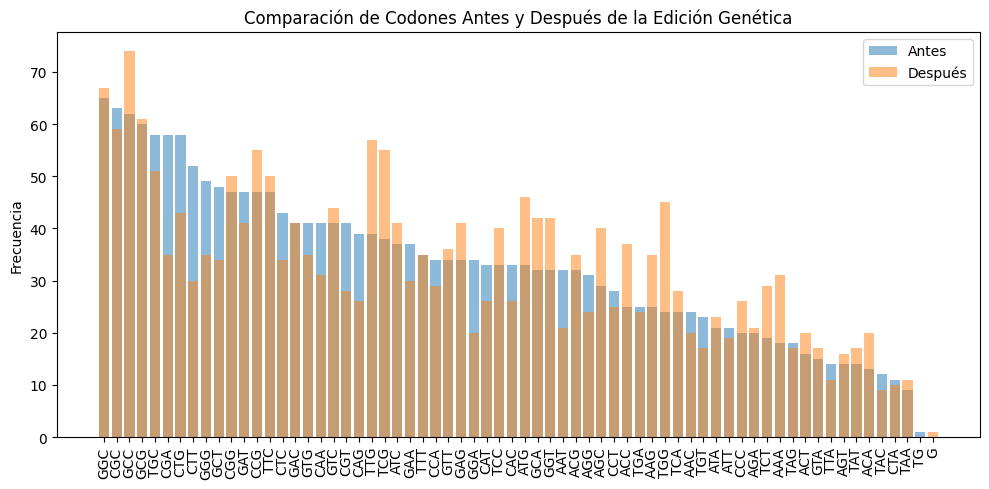

/usr/local/lib/python3.10/dist-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


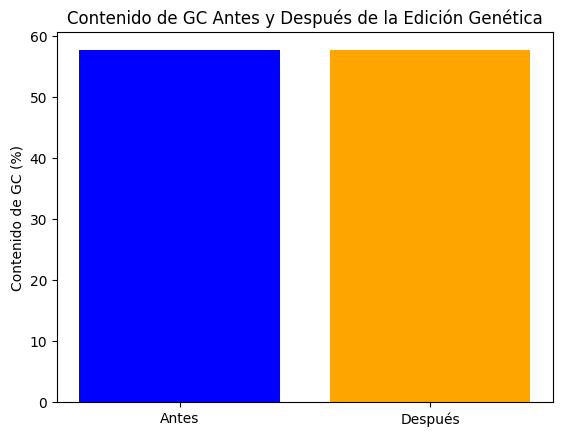

/usr/local/lib/python3.10/dist-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(



Análisis de AY509004.fasta:
Proteína antigua:  *SVKPAVSV*CSSIRRSDSWYSRPSST*VESRTPTFTTRVLNGAYWSEIW ...
Proteína nueva:  *SVKPAVSV*CSSIRRSDSWYSRPSST*VESRTPTFTTRVLNGAYWSEIW ...


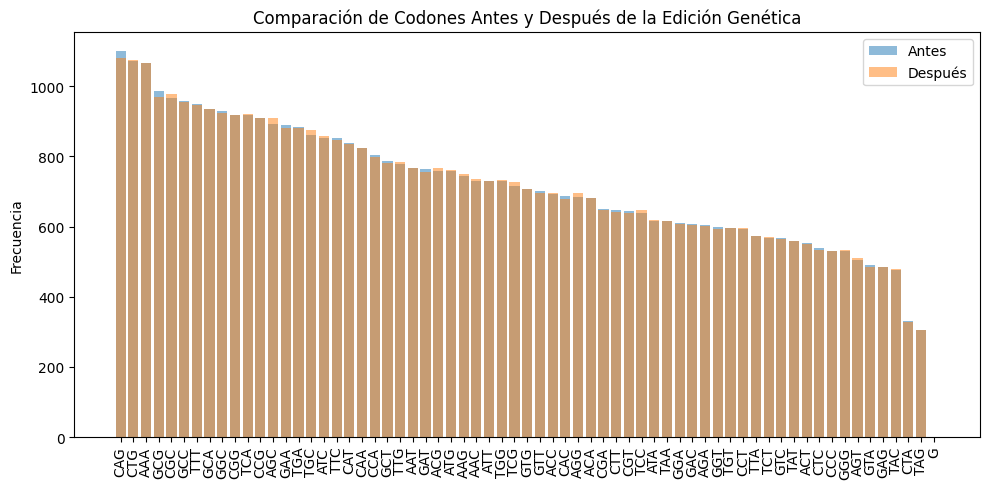

/usr/local/lib/python3.10/dist-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


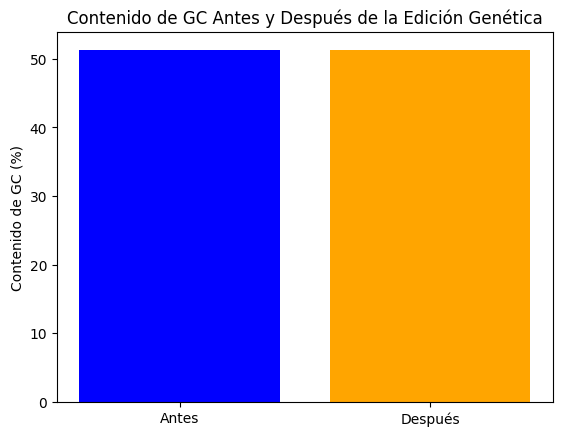

In [6]:
# @title verificar guias

import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# Función para seleccionar la mejor guía para cada archivo
def select_best_guides_per_file(df):
    df_filtered = df[df['Guide'].apply(lambda x: x.isalpha())]
    return df_filtered.sort_values(by=['File', 'Score'], ascending=[True, False]).groupby('File').head(1)

# Función para transformar bacterias simulando ediciones CRISPR/Cas9
def transform_bacteria(guide, sequence):
    mutations = []
    start = sequence.find(guide)
    if start != -1:
        end = start + len(guide)
        mutation_type = random.choice(["deletion", "insertion", "substitution"])
        if mutation_type == "deletion":
            mutated_seq = sequence[:start] + sequence[end:]
            mutations.append((mutation_type, start, sequence[start:end], ""))
        elif mutation_type == "insertion":
            insertion_seq = "ATCG"
            mutated_seq = sequence[:start] + insertion_seq + sequence[start:]
            mutations.append((mutation_type, start, "", insertion_seq))
        elif mutation_type == "substitution":
            substitution_seq = "ATCG"
            mutated_seq = sequence[:start] + substitution_seq + sequence[end:]
            mutations.append((mutation_type, start, sequence[start:end], substitution_seq))
        return mutated_seq, mutations
    else:
        return sequence, []

# Función para analizar y visualizar los resultados
def analyze_and_visualize(file_name, original_sequence, edited_sequence, mutations):
    print(f"\nAnálisis de {file_name}:")
    # Análisis de proteínas y codones
    old_protein = original_sequence.translate()
    new_protein = edited_sequence.translate()
    old_codon_counts = count_codons(original_sequence)
    new_codon_counts = count_codons(edited_sequence)

    print("Proteína antigua: ", old_protein[:50], "...")
    print("Proteína nueva: ", new_protein[:50], "...")
    #print("Codones antes de la edición: ", old_codon_counts)
    #print("Codones después de la edición: ", new_codon_counts)

    # Visualización gráfica de los cambios
    visualize_changes(old_codon_counts, new_codon_counts, original_sequence, edited_sequence)

# Función para contar codones
def count_codons(seq):
    return pd.Series([str(seq[i:i+3]) for i in range(0, len(seq), 3)]).value_counts()

# Función para visualizar los cambios
def visualize_changes(old_codon_counts, new_codon_counts, old_seq, new_seq):
    plt.figure(figsize=(10, 5))
    plt.bar(old_codon_counts.index, old_codon_counts.values, alpha=0.5, label='Antes')
    plt.bar(new_codon_counts.index, new_codon_counts.values, alpha=0.5, label='Después')
    plt.xticks(rotation=90)
    plt.ylabel('Frecuencia')
    plt.title('Comparación de Codones Antes y Después de la Edición Genética')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualización del contenido de GC
    gc_content_before = GC(old_seq)
    gc_content_after = GC(new_seq)
    plt.figure()
    plt.bar(["Antes", "Después"], [gc_content_before, gc_content_after], color=['blue', 'orange'])
    plt.ylabel('Contenido de GC (%)')
    plt.title('Contenido de GC Antes y Después de la Edición Genética')
    plt.show()

# Proceso principal para cada archivo
def process_files(df, file_list):
    for file_name in file_list:
        guide = df[df['File'] == file_name]['Guide'].iloc[0]
        with open(file_name, "r") as fasta_file:
            original_sequence = SeqIO.read(fasta_file, "fasta").seq
            edited_sequence, mutations = transform_bacteria(guide, original_sequence)

            # Análisis y visualización
            analyze_and_visualize(file_name, original_sequence, edited_sequence, mutations)

# Ejemplo de uso
fasta_files = ['U12441.2.fasta', 'AY509004.fasta']  # Lista de tus archivos FASTA
all_guides_df = process_fasta_files(fasta_files)
best_guides_df = select_best_guides_per_file(all_guides_df)
process_files(best_guides_df, fasta_files)



Análisis de U12441.2.fasta:
Proteína antigua:  ACR*SIRIGTGERVTSSKKSPVRVRVLSHSARSSGRLGFQNRKARLAMTT ...
Proteína nueva:  ACR*SIRIGTGERVTSSKKSPVRVRVLSHSARSSGRLGFQNRKARLAMTT ...


/usr/local/lib/python3.10/dist-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


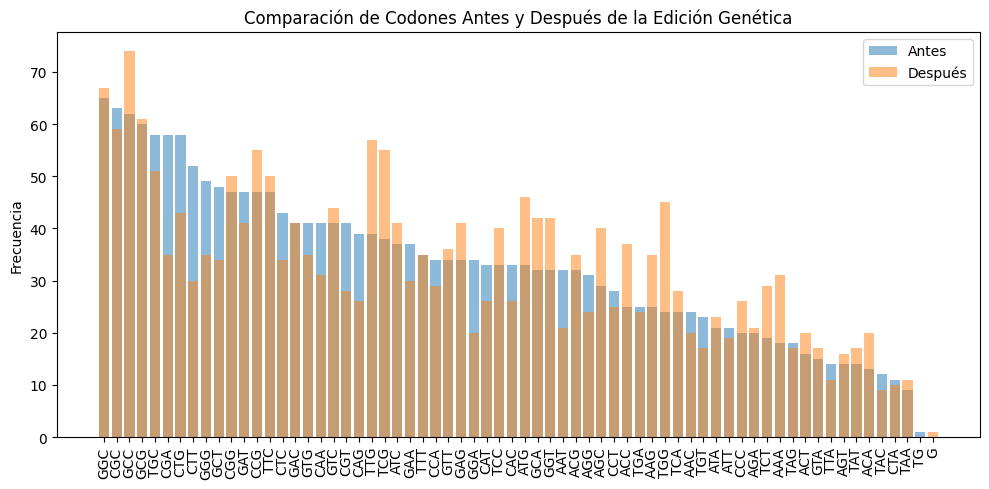

/usr/local/lib/python3.10/dist-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


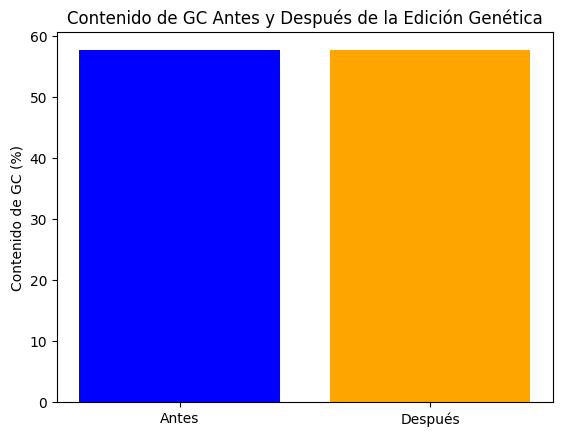

/usr/local/lib/python3.10/dist-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(



Análisis de AY509004.fasta:
Proteína antigua:  *SVKPAVSV*CSSIRRSDSWYSRPSST*VESRTPTFTTRVLNGAYWSEIW ...
Proteína nueva:  *SVKPAVSV*CSSIRRSDSWYSRPSST*VESRTPTFTTRVLNGAYWSEIW ...


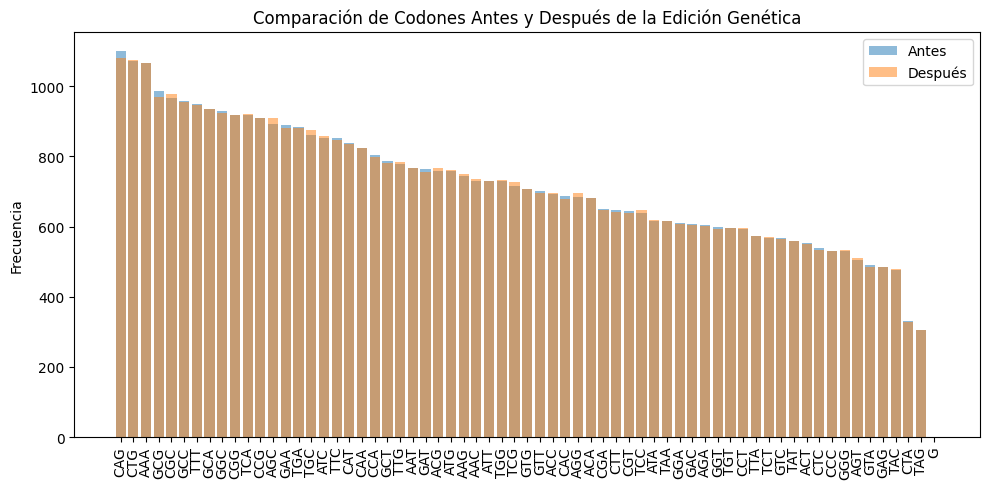

/usr/local/lib/python3.10/dist-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


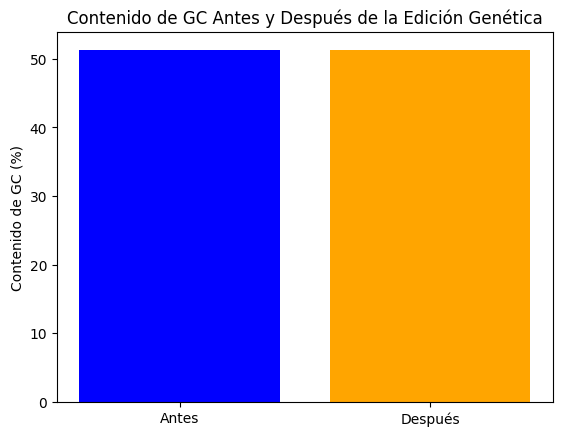

In [7]:
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# ... [El resto de tu código permanece igual]

def process_files2(df, file_list):
    for file_name in file_list:
        if file_name not in df['File'].values:
            print(f"Archivo {file_name} no encontrado en el DataFrame.")
            continue

        guide_df = df[df['File'] == file_name]
        if guide_df.empty:
            print(f"No se encontraron guías para el archivo {file_name}.")
            continue

        guide = guide_df['Guide'].iloc[0]
        try:
            with open(file_name, "r") as fasta_file:
                original_sequence = SeqIO.read(fasta_file, "fasta").seq
                edited_sequence, mutations = transform_bacteria(guide, original_sequence)
                analyze_and_visualize(file_name, original_sequence, edited_sequence, mutations)
        except FileNotFoundError:
            print(f"Archivo {file_name} no encontrado.")

# Ejemplo de uso
#fasta_files = ['U12441.2.fasta', 'AY509004.fasta']
#all_guides_df = process_fasta_files(fasta_files)
#best_guides_df = select_best_guides_per_file(all_guides_df)

#if best_guides_df.empty:
#    print("DataFrame de mejores guías está vacío.")
#else:
#    process_files(best_guides_df, fasta_files)


In [10]:
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# ... [Resto de tus funciones anteriores]

def select_best_guides_per_file(df):
    if df.empty:
        print("Error: El DataFrame proporcionado está vacío.")
        return pd.DataFrame()

    df_filtered = df[df['Guide'].apply(lambda x: x.isalpha())]
    if df_filtered.empty:
        print("Error: No se encontraron guías válidas en el DataFrame.")
        return pd.DataFrame()

    return df_filtered.sort_values(by=['File', 'Score'], ascending=[True, False]).groupby('File').head(1)

def process_files3(best_guides_df, all_guides_df):
    if best_guides_df.empty:
        print("Error: El DataFrame de mejores guías está vacío.")
        return

    if all_guides_df.empty:
        print("Error: El DataFrame de todas las guías está vacío.")
        return

    for file_name in best_guides_df['File'].unique():
        guide_df = best_guides_df[best_guides_df['File'] == file_name]
        if guide_df.empty:
            print(f"Error: No se encontraron guías para el archivo '{file_name}'.")
            continue

        guide = guide_df['Guide'].iloc[0]
        sequence_df = all_guides_df[all_guides_df['File'] == file_name]
        if sequence_df.empty:
            print(f"Error: No se encontraron secuencias para el archivo '{file_name}'.")
            continue

        sequence = sequence_df['Sequence'].iloc[0]  # Asumiendo que hay una columna 'Sequence' en all_guides_df
        try:
            edited_sequence, mutations = transform_bacteria(guide, sequence)
            analyze_and_visualize(file_name, sequence, edited_sequence, mutations)
        except Exception as e:
            print(f"Error al procesar el archivo '{file_name}': {e}")

# Ejemplo de cómo llamar estas funciones desde otro módulo:
# best_guides_df = gs.select_best_guides_per_file(all_guides_df)
# gs.process_files(best_guides_df, all_guides_df)

